In [69]:
import pandas as pd
import numpy as np
import random as rnd
import re
import pickle

# visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

In [70]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split


# from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# from sklearn.metrics import precision_recall_fscore_support
# from sklearn.metrics import precision_score, balanced_accuracy_score

In [71]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture as GMM

from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import homogeneity_score, completeness_score,  v_measure_score

In [72]:
# SEEDS = np.random.randint(0,100, size=5)
SEEDS = [0, 2,  5, 46, 57, 88]
print(SEEDS)

[0, 2, 5, 46, 57, 88]


In [73]:
SEED = 1

# 1. Dataset

In [74]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from scipy import stats

## 1.1 Image Segmentation Dataset

In [125]:
features = 'REGION-CENTROID-COL,REGION-CENTROID-ROW,REGION-PIXEL-COUNT, SHORT-LINE-DENSITY-5,SHORT-LINE-DENSITY-2,VEDGE-MEAN,VEDGE-SD,HEDGE-MEAN,HEDGE-SD,INTENSITY-MEAN,RAWRED-MEAN,RAWBLUE-MEAN,RAWGREEN-MEAN,EXRED-MEAN,EXBLUE-MEAN,EXGREEN-MEAN,VALUE-MEAN,SATURATION-MEAN,HUE-MEAN'
col_names = features.split(',') + ['Class']
# print(col_names)

dataset_dir = '../Datasets/statlog_image_segmentation'
df_ims = pd.read_csv(dataset_dir + '/segment.dat', names=col_names, sep=' ')
df_ims.shape

print(df_ims['Class'].unique())

# df_ims.describe()

## Separate labels
column_names = df_ims.columns
y = df_ims['Class'].copy().values
X = df_ims.drop(['Class'], axis=1).values
# to 0 - N-1
y = y-1

## Standardize feature data
scaler = StandardScaler()

X_scaled = scaler.fit_transform(X)

new_names = ['x%d'%(i+1) for i in range(len(column_names[:-1]))]
df = pd.DataFrame(X_scaled, columns=new_names)
df['Class'] = y

df_ims_scaled = df

## image segmentation
# column_names = df_ims_scaled.columns
# y = df_ims_scaled['Class'].copy().values
# X = df_ims_scaled.drop(['Class'], axis=1).values

y = df_ims_scaled['Class']
X = df_ims_scaled.drop(['Class'], axis=1)


X_ims, X_ims_test, y_ims, y_ims_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

df_ims = X_ims.copy()
df_ims['Class'] = y_ims

# df_ims_scaled.head()
# X_ims.head()
# df_ims.head()

[6 3 2 7 1 4 5]


## 1.2 Audit Dataset

In [76]:
dataset_dir = '../Datasets/audit_data/'
df_aud = pd.read_csv(dataset_dir + '/audit_risk.csv', sep=',')

column_names = df_aud.columns

df_aud = df_aud.dropna()
s1 = df_aud['LOCATION_ID']
isnum = s1.str.isnumeric()
df_aud = df_aud[isnum]

y = df_aud['Risk'].astype('int')
X = df_aud.drop(['Risk'], axis=1).values

## Standardize feature data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# new_names = ['x%d'%(i+1) for i in range(len(column_names[:-1]))]
df_aud_scaled = pd.DataFrame(X_scaled, columns=column_names[:-1])
df_aud_scaled['Risk'] = y

X = df_aud_scaled.drop(['Risk'], axis=1)

X_aud, X_aud_test, y_aud, y_aud_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

df_aud = X_aud.copy()
df_aud['Class'] = y_aud

# df_aud_scaled.head()
# X_aud.head()
# df_aud.head()

# 2. K-Means

In [77]:
def kmclustering(X_scaled, seeds, k_max, k_min=2):
    km_sse = []
    km_sil = []

    k_max = 10
    for k in range(k_min, k_max+1):
        inertias = []
        sil = []
        db = []

        for seed in seeds:
            ## K-Means
            km = KMeans(n_clusters=k, random_state=seed, n_jobs=-1)
            km = km.fit(X_scaled)
            labels = km.predict(X_scaled)

            inertias.append(km.inertia_)
            silhouette = silhouette_score(X_scaled, labels, metric='euclidean')
            sil.append(silhouette)   

        ## average
        km_sse.append(np.mean(inertias))
        km_sil.append(np.mean(sil))
        
    return (km_sse, km_sil)

## 2.1 Image Segmentation

In [95]:
## image segmentation
k_max = 10
k_min = 2

x = list(range(k_min, k_max+1))

km_sse, km_sil = kmclustering(X_ims, SEEDS, k_max=k_max, k_min=k_min)

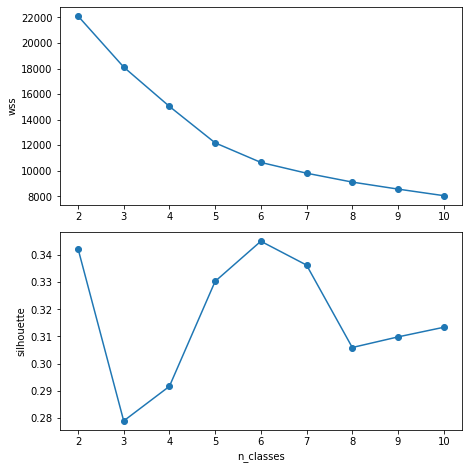

In [96]:
fig = plt.figure(figsize=(6.4,6.4),constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig)

# Within-Cluster-Sum of Squared Errors
ax1 = fig.add_subplot(gs[0, 0])
# ax1.set_facecolor('None')
ax1.plot(x, km_sse,'o-')
ax1.set_ylabel('wss')

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(x, km_sil, 'o-')
ax2.set_xlabel('n_classes')
ax2.set_ylabel('silhouette')

# fig.suptitle("GridSpec")
# # format_axes(fig)

plt.show()

In [55]:
clf_km = KMeans(n_clusters=6, random_state=SEED, n_jobs=-1)
clf_km = clf_km.fit(X_ims)
labels = clf_km.predict(X_ims)

In [56]:
df_ims_new = X_ims.copy()
df_ims_new['Class'] = labels

In [57]:
df_ims_new['Class'].value_counts()

0    704
2    511
4    298
1    261
5     66
3      8
Name: Class, dtype: int64

In [39]:
print(homogeneity_score(y_ims, labels))
print(completeness_score(y_ims, labels))
print(v_measure_score(y_ims, labels))

0.5574547548053072
0.7550026607774866
0.6413614920285662


In [53]:
cols = df_ims.columns
v=[cols[0], cols[8], cols[12]]

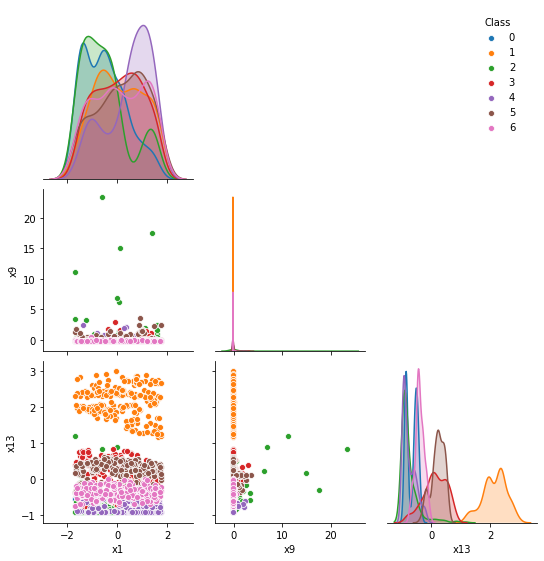

In [54]:
g = sns.pairplot(df_ims, hue="Class", vars=v, corner=True)
g._legend.set_bbox_to_anchor((0.9, 0.9))

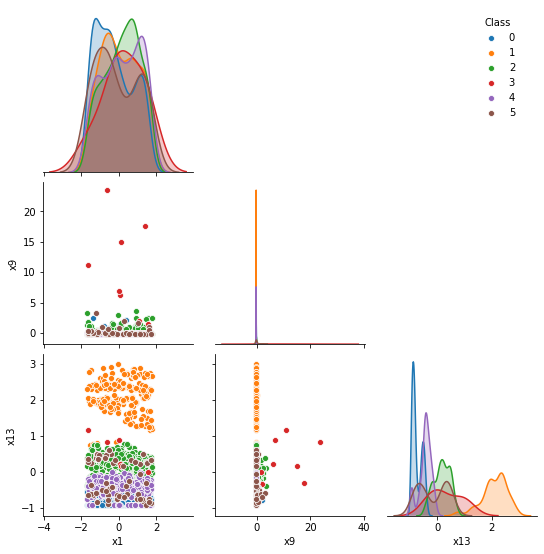

In [58]:
g = sns.pairplot(df_ims_new, hue="Class", vars=v, corner=True)
g._legend.set_bbox_to_anchor((0.9, 0.9))

## 2.2 Audit

In [86]:
k_max = 10
k_min = 2

x = list(range(k_min, k_max+1))

km_sse, km_sil = kmclustering(X_aud, SEEDS, k_max=k_max, k_min=k_min)

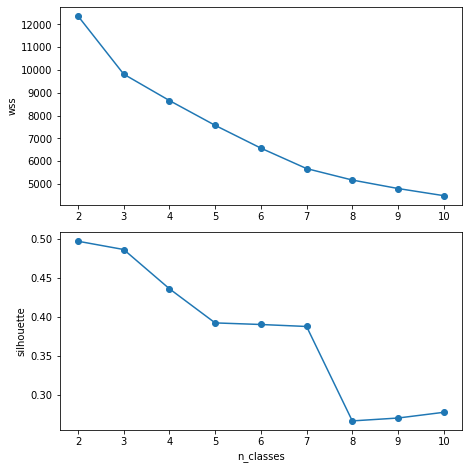

In [89]:
fig = plt.figure(figsize=(6.4,6.4),constrained_layout=True)
gs = gridspec.GridSpec(2, 1, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
# ax1.set_facecolor('None')
ax1.plot(x, km_sse,'o-')
ax1.set_ylabel('wss')

# # identical to ax1 = plt.subplot(gs.new_subplotspec((0, 0), colspan=3))

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(x, km_sil, 'o-')
ax2.set_xlabel('n_classes')
ax2.set_ylabel('silhouette')

# fig.suptitle("GridSpec")
# # format_axes(fig)

plt.show()

In [61]:
clf_km = KMeans(n_clusters=2, random_state=SEED, n_jobs=-1)
clf_km = clf_km.fit(X_aud)
labels = clf_km.predict(X_aud)

df_aud_new = X_aud.copy()
df_aud_new['Class'] = labels

In [62]:
df_aud_new['Class'].value_counts()

0    505
1    112
Name: Class, dtype: int64

In [63]:
print(homogeneity_score(y_aud, labels))
print(completeness_score(y_aud, labels))
print(v_measure_score(y_aud, labels))

0.2975829858587564
0.4220420286314209
0.3490499204700431


In [66]:
cols = df_aud.columns
v=[cols[0], cols[8], cols[12]]

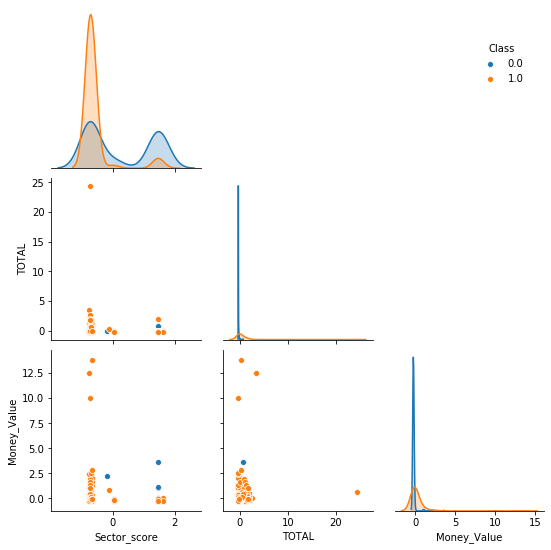

In [67]:
g = sns.pairplot(df_aud, hue="Class", vars=v, corner=True)
g._legend.set_bbox_to_anchor((0.9, 0.9))

# 3. EM

In [121]:
def gmm_clusting(X_scaled, seeds, k_max, k_min=2):
    gmm_score = []
    gmm_bic = []

    for k in range(k_min, k_max+1):  
        gs = []
        bic = []
        for seed in seeds:
            ## EM GaussianMixture
            gmm = GMM(n_components=k, random_state=seed, n_init=10, max_iter=1000)
            gmm = gmm.fit(X_scaled)

            gs.append(gmm.score(X_scaled))
            bic.append(gmm.bic(X_scaled))        

        ## average
        gmm_score.append(np.mean(gs))
        gmm_bic.append(np.mean(bic))
        
    return (gmm_score, gmm_bic)

In [122]:
k_max = 16
k_min = 2

x = list(range(k_min, k_max+1))

gmm_score_ims, gmm_bic_ims = gmm_clusting(X_ims, SEEDS, k_max=k_max, k_min=k_min)

In [123]:
k_max = 16
k_min = 2

x = list(range(k_min, k_max+1))

gmm_score_aud, gmm_bic_aud = gmm_clusting(X_aud, SEEDS, k_max=k_max, k_min=k_min)

Text(0, 0.5, 'score')

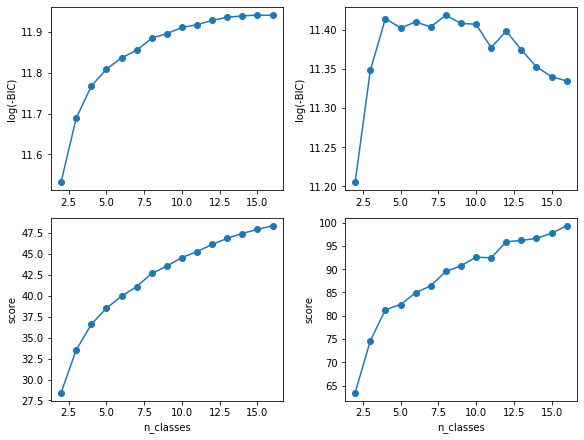

In [124]:
fig = plt.figure(figsize=(8, 6),constrained_layout=True)
gs = gridspec.GridSpec(2, 2, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x, [np.log(-x) for x in gmm_bic_ims], 'o-')
ax1.set_ylabel('log(-BIC)')

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(x, gmm_score_ims, 'o-')
ax2.set_xlabel('n_classes')
ax2.set_ylabel('score')

ax1 = fig.add_subplot(gs[0, 1])
ax1.plot(x, [np.log(-x) for x in gmm_bic_aud], 'o-')
ax1.set_ylabel('log(-BIC)')

ax2 = fig.add_subplot(gs[1, 1])
ax2.plot(x, gmm_score_aud, 'o-')
ax2.set_xlabel('n_classes')
ax2.set_ylabel('score')